In [11]:
import pandas as pd
import numpy as np
from sklearn import datasets as ds
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
#load datasets
X_train, y_train = ds.load_svmlight_file('data/a9a')
X_train = X_train.todense()
X_train = np.array(X_train)

X_test, y_test = ds.load_svmlight_file('data/a9a.t')
X_test = X_test.todense()
X_test = np.array(X_test)
#X_test 123rd col: all zeros
X_test = np.concatenate((X_test, np.zeros((X_test.shape[0], 1))), axis=1)

In [13]:
#transformation trick: combine w and b together
X_train = np.concatenate((X_train, np.ones((X_train.shape[0], 1))), axis=1)
X_test = np.concatenate((X_test, np.ones((X_test.shape[0], 1))), axis=1)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((32561, 124), (32561,), (16281, 124), (16281,))

In [14]:
#param init:all zeros
def zeroInit():
    #[w b]^T
    return np.zeros(X_train.shape[1])

# define loss
def loss(X, y, w, C):
    return 1/2 * np.sum(np.square(w[:-1])) + C * np.sum(hingeLoss(X, y, w))

# define metric
def accuracy(y_true, y_pred):
    return np.sum(y_true==y_pred) / len(y_true)

#define hinge loss
def hingeLoss(X, y, w):
    #cannot use np.max here: two arrays
    return np.maximum(0, 1-np.multiply(y, np.dot(X, w)))

#cal gradients
def gradient(X, y, w, C):
    margin = 1-np.multiply(y, np.dot(X, w))
    minus_y = -y
    minus_y[margin<0] = 0
    res = w + C * np.dot(X.T, minus_y)
    res[-1] -= w[-1] #b
    return res

# define prediction
def predict(X, w, threshold):
    res = np.dot(X, w)
    res[res>=threshold] = 1
    res[res<threshold] = -1
    return res

def getBatch(X, y, batch_size):
    idx = np.random.choice(X.shape[0], batch_size, replace=False)
    return X[idx], y[idx]

# for plotting curves
class RecordContainer(object):
    def __init__(self, X_test, y_test):
        self.train_history = {}
        self.train_history['loss'] = []
        self.train_history['accuracy'] = []
        self.test_history = {}
        self.test_history['loss'] = []
        self.test_history['accuracy'] = []      
        self.X_test = X_test
        self.y_test = y_test
        
    def recordLoss(self, X_batch, y_batch, w, C, threshold):
        train_loss = loss(X_batch, y_batch, w, C)
        self.train_history['loss'].append(train_loss)
        test_loss = loss(self.X_test, self.y_test, w, C)
        self.test_history['loss'].append(test_loss)

        train_accuracy = accuracy(y_batch, predict(X_batch, w, threshold))
        self.train_history['accuracy'].append(train_accuracy)
        test_accuracy = accuracy(y_test, predict(X_test, w, threshold))
        self.test_history['accuracy'].append(test_accuracy)
        return train_loss, test_loss, train_accuracy, test_accuracy
    
    def getBestTestAccuracy(self):
        return max(self.test_history['accuracy'])
    
    def getBestTestLoss(self):
        return min(self.test_history['loss'])
    
    def plotting(self, ptype='loss', title = ''):#loss/accuracy
        plt.title(title)
        plt.xlabel('iteration number')
        plt.ylabel(ptype)
        plt.plot(range(len(self.train_history[ptype])), self.train_history[ptype],'r', label='train '+ptype)  
        plt.plot(range(len(self.test_history[ptype])), self.test_history[ptype],'b',label='test '+ptype)  
        plt.legend()
        plt.grid()
        plt.show()

In [15]:
class NAGOptimizer(object):#Nesterov accelerated gradient
    def __init__(self, rho = 0.9):
        self.v = 0
        self.rho = rho
    
    def getNextDirection(self, X_train, y_train, w, C, learning_rate, cur_run):
        dw = gradient(X_train, y_train, w, C)
        prev_v = self.v
        self.v = self.v * self.rho - learning_rate * dw
        return -self.rho * prev_v + (1 + self.rho) * self.v

class RMSPropOptimizer(object):
    def __init__(self, decay_rate = 0.9):
        self.grad_squared = 0
        self.decay_rate = decay_rate
    
    def getNextDirection(self, X_train, y_train, w, C, learning_rate, cur_run):
        dw = gradient(X_train, y_train, w, C)
        self.grad_squared = self.decay_rate * self.grad_squared + (1 - self.decay_rate) * dw * dw
        return -learning_rate * dw / (np.sqrt(self.grad_squared) + 1e-7)

class AdaDeltaOptimizer(object):
    def __init__(self, gamma = 0.95):
        self.numerator = 0
        self.denominator = 0
        self.gamma = gamma
    
    def getNextDirection(self, X_train, y_train, w, C, learning_rate, cur_run):
        dw = gradient(X_train, y_train, w, C)
        self.denominator = self.gamma * self.denominator + (1 - self.gamma) * dw * dw
        res = -np.sqrt((self.numerator + 1e-6)/(self.denominator + 1e-6)) * dw
        self.numerator = self.gamma * self.numerator + (1 - self.gamma) * res * res
        return res
     
class AdamOptimizer(object):
    def __init__(self, beta1 = 0.9, beta2 = 0.999):
        self.first_moment = 0
        self.second_moment = 0
        self.beta1 = beta1
        self.beta2 = beta2
        
    def getNextDirection(self, X_train, y_train, w, C, learning_rate, cur_run):
        dw = gradient(X_train, y_train, w, C)
        self.first_moment = self.beta1 * self.first_moment + (1 - self.beta1) * dw
        self.second_moment = self.beta2 * self.second_moment + (1 - self.beta2) * dw * dw
        first_unbias = self.first_moment / (1 - self.beta1 ** cur_run)
        second_unbias = self.second_moment / (1 - self.beta2 ** cur_run)
        return -learning_rate * first_unbias / (np.sqrt(second_unbias) + 1e-7)

iter 1000: 247.312182536 31119.2324274 0.838646274799
iter 2000: 183.143015049 31340.1728361 0.837417849026
iter 3000: 168.772291934 30675.1062562 0.842884343714
iter 4000: 216.226825677 31117.7866943 0.837049321295
iter 5000: 162.605470238 30982.6577556 0.83858485351
iter 6000: 177.947721761 30529.0364393 0.839874700571
iter 7000: 209.183025173 31512.9901823 0.836680793563
iter 8000: 210.900611375 30974.7109741 0.835268103925
iter 9000: 177.506626371 30288.2205286 0.839014802531
best NAG test loss:  29403.5857525
best NAG test accuracy:  0.847982310669


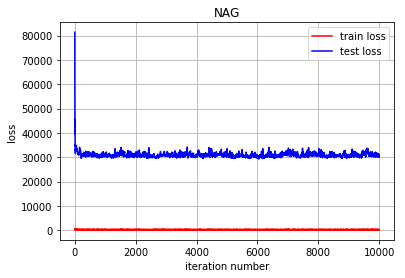

iter 1000: 180.562221156 37300.6037755 0.763773723973
iter 2000: 206.616459684 35743.4232239 0.76389656655
iter 3000: 251.716766745 34354.5962881 0.780848842209
iter 4000: 243.023380102 33007.1966532 0.809225477551
iter 5000: 201.092773084 31712.7401227 0.829371660217
iter 6000: 203.72065169 30785.8887927 0.836435108409
iter 7000: 260.042110379 30204.2422794 0.840120385726
iter 8000: 203.084949295 29810.5021195 0.842700079848
iter 9000: 197.684328859 29542.7886375 0.843682820466
best RMSProp test loss:  29356.619792
best RMSProp test accuracy:  0.844788403661


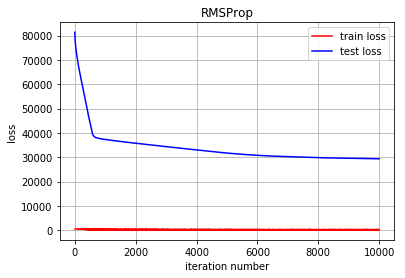

iter 1000: 170.093865291 28849.1811836 0.849886370616
iter 2000: 126.601189157 28819.0882048 0.848903629998
iter 3000: 206.665950936 28801.3411313 0.847613782937
iter 4000: 226.862235468 28741.4307946 0.848596523555
iter 5000: 187.97950278 28770.3061671 0.849824949327
iter 6000: 177.658081378 28754.4352685 0.848657944844
iter 7000: 230.598844365 28831.9183956 0.847798046803
iter 8000: 118.056541748 29026.9679503 0.846508199742
iter 9000: 188.274578515 28821.8438149 0.850684847368
best AdaDelta test loss:  28651.080813
best AdaDelta test accuracy:  0.851851851852


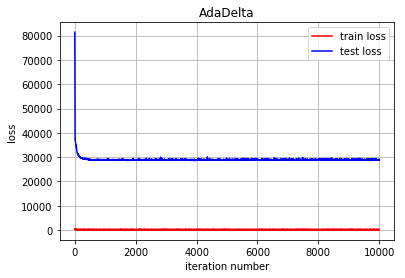

iter 1000: 207.709224194 37625.8794246 0.763773723973
iter 2000: 236.181340344 36459.8478056 0.763773723973
iter 3000: 228.865962086 35368.377978 0.766783367115
iter 4000: 205.283313899 34198.084056 0.785946809164
iter 5000: 221.669140594 32975.364755 0.809655426571
iter 6000: 217.141148979 31734.0955029 0.828450340888
iter 7000: 192.866868257 30820.757401 0.835575210368
iter 8000: 235.91421577 30232.6580794 0.840980283766
iter 9000: 127.099266838 29823.8166235 0.843314292734
best Adam test loss:  29537.1248563
best Adam test accuracy:  0.84392850562


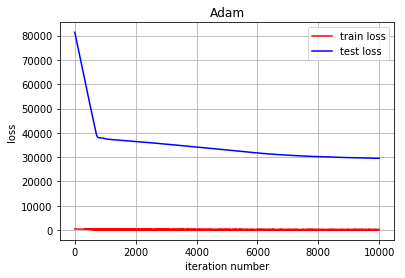

In [25]:
learning_rate = 0.0001
iter_num = 10000
C = 5
threshold = 0
batch_size = 100
verbose = 1000

#select optimizer
instance_list = [NAGOptimizer(0.99), RMSPropOptimizer(0.99), AdaDeltaOptimizer(0.99), AdamOptimizer(0.99,0.999)]
label_list = ['NAG','RMSProp','AdaDelta', 'Adam']
recorder_list = []
for i in range(len(instance_list)):
    recorder_list.append(RecordContainer(X_test, y_test))

for opt_idx in range(len(instance_list)):
    #initialize w, b
    w = zeroInit()

    instance = instance_list[opt_idx]
    recorder = recorder_list[opt_idx]
    label = label_list[opt_idx]

    #start training process
    for i in range(1, iter_num):
        X_batch, y_batch = getBatch(X_train, y_train, batch_size)
        train_loss, test_loss, train_accuracy, test_accuracy = recorder.recordLoss(X_batch, y_batch, w, C, threshold)
        if i % verbose == 0:
            print('iter ' + str(i) + ':', train_loss, test_loss, test_accuracy)
        w += instance.getNextDirection(X_batch, y_batch, w, C, learning_rate, i)
    print('best '+label+' test loss: ', recorder.getBestTestLoss())
    print('best '+label+' test accuracy: ', recorder.getBestTestAccuracy())

    # plotting loss
    recorder.plotting('loss', label)
#     recorder.plotting('accuracy', label)

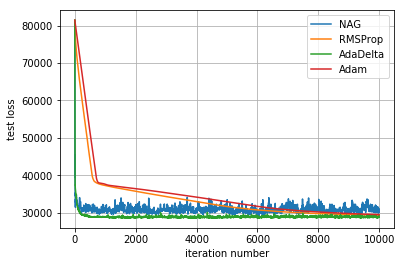

In [28]:
# plt.title(title)
plt.xlabel('iteration number')
plt.ylabel('test loss')
for opt_idx in range(len(recorder_list)):
    recorder = recorder_list[opt_idx]
    label = label_list[opt_idx]
    plt.plot(range(len(recorder.test_history['loss'])), recorder.test_history['loss'],label = label)  
plt.legend()
plt.grid()
plt.show()

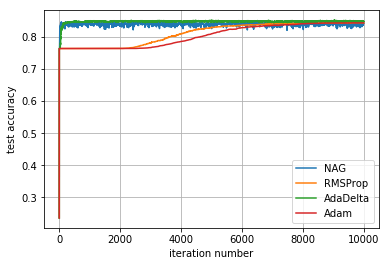

In [29]:
# plt.title(title)
plt.xlabel('iteration number')
plt.ylabel('test accuracy')
for opt_idx in range(len(recorder_list)):
    recorder = recorder_list[opt_idx]
    label = label_list[opt_idx]
    plt.plot(range(len(recorder.test_history['accuracy'])), recorder.test_history['accuracy'],label = label)  
plt.legend()
plt.grid()
plt.show()